In [38]:
import math
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
kbt=2.494339
minS=1.0
maxS=112.0
nbin=20

In [40]:
data=pd.read_csv("COLVAR",sep="\s+", header=None, skiprows=1,usecols=[1,2,3]) 
data.columns=['s(R)','z(R)','bias']
data['s(R)']=data['s(R)'].round(2)
data

,s(R),z(R),bias
0,1.90,0.011533,149.325585
1,1.82,0.011707,148.022618
2,1.72,0.012545,147.008204
3,1.93,0.009537,143.402185
4,1.82,0.009520,141.415963
...,...,...,...
13329,90.42,0.026455,199.897369
13330,92.33,0.025622,198.335748
13331,94.45,0.024892,194.978573
13332,95.89,0.025026,192.737358


## Calculate Maximum bias

In [41]:
bmax=data['bias'].max()

# Calculate Boltzmann weights and write them to a file named "sR.weight"

In [42]:
data['weights']=np.exp((data['bias']-bmax)/kbt)
data.to_csv("sR.weight",index=False,sep="\t",columns=['s(R)','weights'])

## Calculate bin width

In [43]:
bin_width = round((maxS-minS)/float(nbin-1),2)
bin_width

5.84

# Block averaging

## Binning of data using cut: Create 20 equal-sized bins

In [44]:
weightdf=pd.read_csv('sR.weight',sep="\t")
weightdf.columns=['s(R)','weights']
weightdf['bin_index'] = pd.cut(weightdf['s(R)'],bins=20,labels=[i for i in range(20)]) 
weightdf

,s(R),weights,bin_index
0,1.90,3.688909e-12,0
1,1.82,2.187942e-12,0
2,1.72,1.456847e-12,0
3,1.93,3.432121e-13,0
4,1.82,1.547881e-13,0
...,...,...,...
13329,90.42,2.355348e-03,16
13330,92.33,1.259384e-03,16
13331,94.45,3.278185e-04,16
13332,95.89,1.334784e-04,17


In [45]:
bin_list=list(weightdf['bin_index'].unique())
bin_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [46]:
block_size = np.array([i for i in range(10,510,10)])
block_size

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500])

In [47]:
nblocks = np.array(len(data)/block_size).astype(int)
nblocks

array([1333,  666,  444,  333,  266,  222,  190,  166,  148,  133,  121,
        111,  102,   95,   88,   83,   78,   74,   70,   66,   63,   60,
         57,   55,   53,   51,   49,   47,   45,   44,   43,   41,   40,
         39,   38,   37,   36,   35,   34,   33,   32,   31,   31,   30,
         29,   28,   28,   27,   27,   26])

In [48]:
xbar_xbarsq=[]
for i in range(0,len(nblocks)):
    xbar=pd.Series(index=bin_list,dtype=float,data=0)
    xbarsq=pd.Series(index=bin_list,dtype=float,data=0)
    for nblock in range(0, nblocks[i]):
        start = nblock * block_size[i]
        end = start + block_size[i]
        weightcopy=weightdf.copy()
        grp=weightcopy[start:end].groupby('bin_index')
        block_ave=grp['weights'].sum()/block_size[i]
        ind_list=list(block_ave.index)
        for ind in range(len(ind_list)):
            xbar[ind]+=block_ave[ind]
            xbarsq[ind]+=block_ave[ind]*block_ave[ind]
    xbar_xbarsq.append((nblocks[i],block_size[i],xbar,xbarsq))
        
length=len(xbar_xbarsq)
length

50

<AxesSubplot:xlabel='s(R)'>

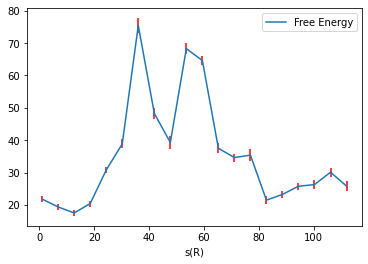

In [60]:
sR_series = pd.Series(dtype=float,data=[(minS + (float(i) * bin_width)) for i in range(len(bin_list))])
for i in range(length):
    numblock=xbar_xbarsq[i][0]
    blocksize=xbar_xbarsq[i][1]
    result=pd.DataFrame()
    result['s(R)']=sR_series
    result['Weight']=xbar_xbarsq[i][2]/blocksize
    result['Free Energy']=-kbt * np.log(result['Weight'])
    result['<x**2>']= (xbar_xbarsq[i][3]-result['Weight']**2)/(blocksize-1)
    result['error']=kbt*(np.sqrt(result['<x**2>']/blocksize))/result['Weight']
    outdf=result[['s(R)','Free Energy','error']].round(2)
    outdf.to_csv(f'fes{blocksize}.dat',sep="\t",index=False)
outdf.plot('s(R)','Free Energy',yerr='error',ecolor='red')

In [50]:
%%bash
echo > err.blocks
for i in {10..500..10}
do
 a=$(awk '{tot+=$3}END{print tot/NR}' fes"$i".dat)
 echo $i $a >> err.blocks
done

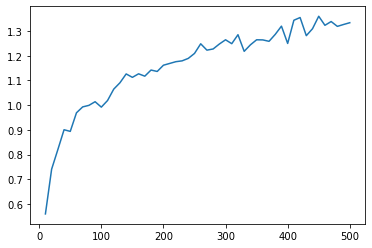

In [51]:
df=pd.read_csv("err.blocks",sep="\s+",header=None,skiprows=1)
plt.plot(df[0],df[1])